## Denoising with the deep decoder and the DIP

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt

from utils.common_utils import *
from scipy.io import loadmat,savemat

import matplotlib.pyplot as plt
%matplotlib inline

import os

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from models import *
from include import *
import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


plt.rcParams["figure.figsize"] = (10, 8)

import random
import torch.backends.cudnn as cudnn

random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = True
np.random.seed(0)
# !nvidia-smi

num GPUs 1


In [2]:
def Crop_image(img, d=32):  
    new_size = (img.shape[0] - img.shape[0] % d, 
                img.shape[1] - img.shape[1] % d)

    img_cropped = img[
           int((img.shape[0] - new_size[0])/2):int((img.shape[0] + new_size[0])/2), 
           int((img.shape[1] - new_size[1])/2):int((img.shape[1] + new_size[1])/2)]

    
    return img_cropped

def rmse(predictions, targets):
       return np.sqrt(((predictions - targets) ** 2).mean())

## Load Data

In [3]:
data1 = loadmat('Simulation_noise40_res_0.5')
print(data1.keys())
noise_data = data1['Simulation_noise']
segmentation = data1['segmentation']
data2 =loadmat('Phantom_res512')
print(data2.keys())
clean_data = data2['Simulation']
clean_data.shape

dict_keys(['__header__', '__version__', '__globals__', 'Simulation_noise', 'segmentation'])
dict_keys(['__header__', '__version__', '__globals__', 'Simulation', 'segmentation'])


(256, 256)

In [4]:
a = Crop_image(np.real(noise_data))
b = Crop_image(np.imag(noise_data))
c = Crop_image(np.real(clean_data))
d = Crop_image(np.imag(clean_data))
Msk = segmentation>0.34
Msk = Msk+0.0
print(std := np.std(noise_data).item(), mean := np.mean([noise_data.real, noise_data.imag]).item())
Msk.shape

0.3148546124945991 -0.08276367191326663


(256, 256)

(-0.5, 255.5, 255.5, -0.5)

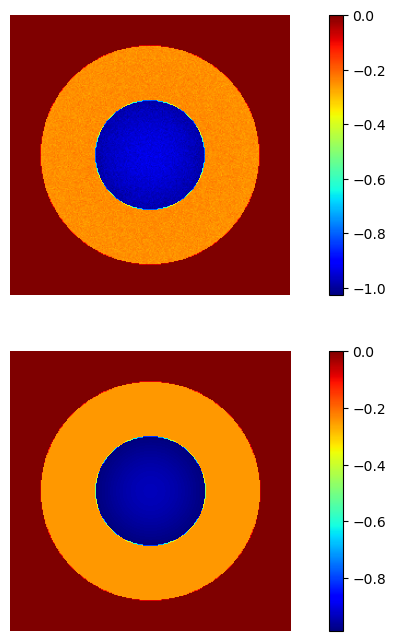

In [5]:
plt.subplot(2,1,1)
plt.imshow(a*Msk)
plt.jet()
plt.colorbar()
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(c*Msk,)
plt.jet()
plt.colorbar()
plt.axis('off')

In [6]:
# Data concatation
ab = np.concatenate((np.expand_dims(a,axis=0)*Msk,np.expand_dims(b,axis=0)*Msk),axis=0)
cd = np.concatenate((np.expand_dims(c,axis=0)*Msk,np.expand_dims(d,axis=0)*Msk),axis=0)
ab.shape

sigma_ = np.std(a[:30,:30])
sigma_
n = ab.size
sigma_

0.0115619390873746

## DIP(Over-Parameterized)

In [7]:
# DIP network parameter setting
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

# reg_noise_std = 1./30. # set to 1./20. for sigma=50
reg_noise_std =1/50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 200
exp_weight=0.99
dtype = torch.cuda.FloatTensor

num_iter = 1000
input_depth = 2 
figsize = 4 

# skip_n33d=128
# skip_n33u=128
# skip_n11=4
# num_scales=5
n_channels=2
upsample_mode=['nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear', 'bilinear']
downsample_mode='stride'
act_fun='LeakyReLU'
net = skip(input_depth, n_channels, num_channels_down = [64, 64, 128, 256, 256],
                                            num_channels_up =  [64, 64, 128, 256, 256] ,
                                            num_channels_skip = [0, 0, 0, 20, 20], 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=False, need_bias=True, pad=pad, act_fun=act_fun).type(dtype)

In [8]:
# net_input = get_noise(input_depth, INPUT, (256, 256)).type(dtype).detach()
device=torch.device('cuda:0')
img_noisy_torch = np_to_torch(ab).type(dtype)
img_noisy_torch = (img_noisy_torch - mean) / std
net_input = img_noisy_torch
mse = torch.nn.MSELoss().type(dtype)


Starting optimization with ADAM


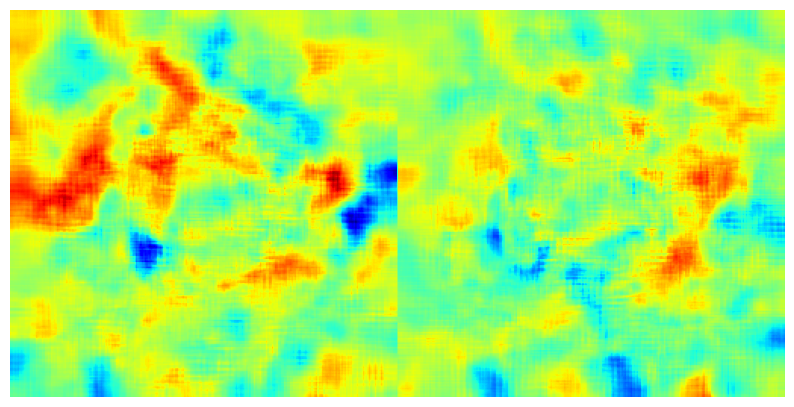

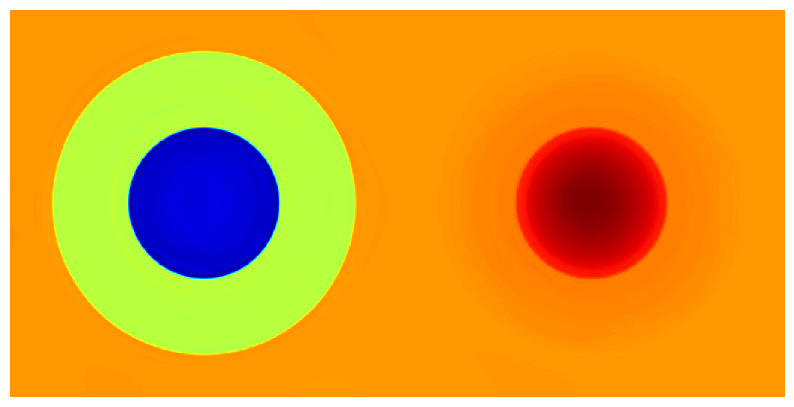

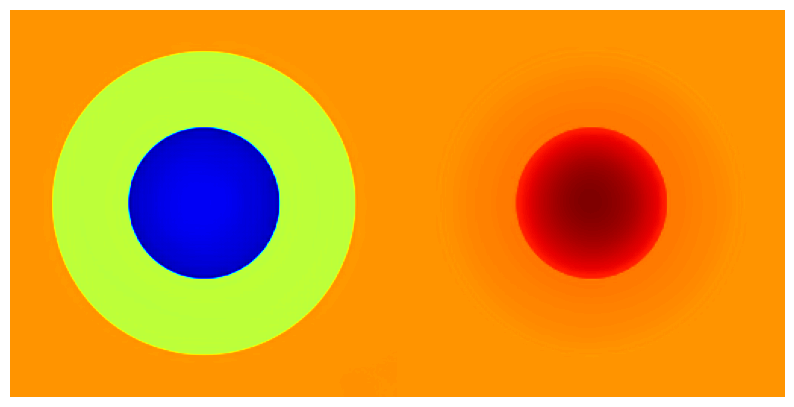

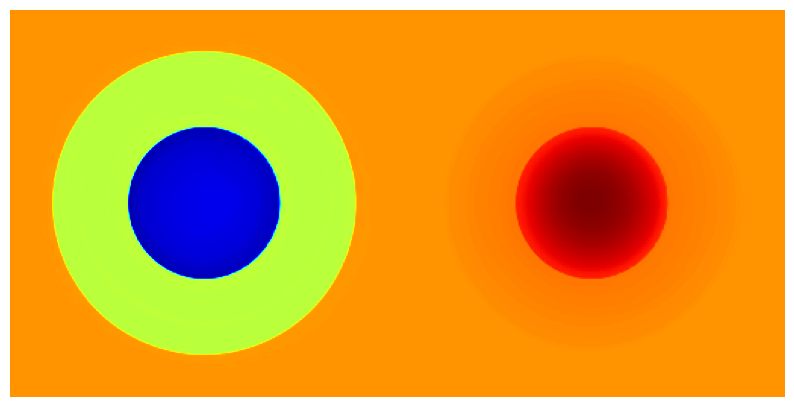

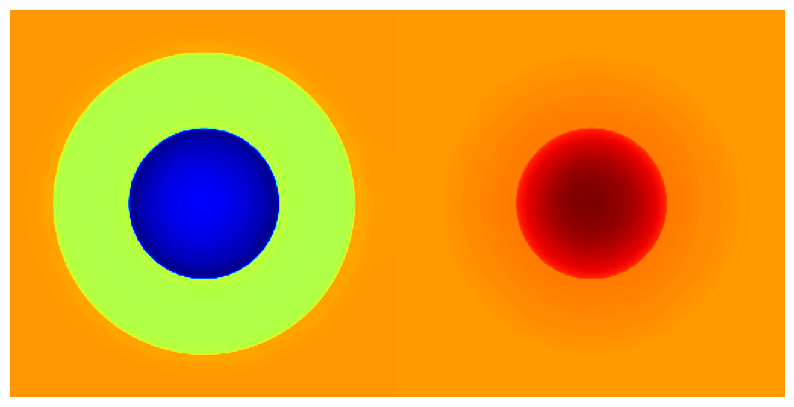

In [9]:
net_input_saved = net_input.detach().clone()
# torch.manual_seed(0)
# noise = get_noise(2, INPUT, (256, 256), noise_type='n').type(dtype).detach()
noise = torch.normal(0,1,size=(1,2,256,256)).to(device)
out_avg = True
last_net = None
psrn_noisy_last = 0
PLOT= True

global min_loss
global SURE_losses
global Divergences_terms

SURE_losses = np.zeros(num_iter)
Divergences_terms = np.zeros(num_iter)
min_loss=np.inf

i = 0
def closure():
   
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input).to(device)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

     
    fidelity_loss = mse(out, img_noisy_torch)

    
    # epsilon = 1*1e-3  # * torch.max(net_input)
    # epsilon = torch.max(net_input)*1e-3 
    epsilon = sigma_ * 1e-2*3*2
    eta = noise.normal_()
    net_input_perturbed = net_input.data.clone() + (eta * epsilon)
    out_perturbed = net(net_input_perturbed)
    dx=out_perturbed - out
    eta_dx = torch.sum(eta * dx)  # Inner product between eta and (x_perturbed-x). They must have the same dimensions
    MCdiv = eta_dx / epsilon
    div_term = 2. * sigma_ ** 2 * MCdiv / n
    
    global SURE_losses
    global Divergences_terms

    SURE_loss = fidelity_loss - sigma_ ** 2 + div_term

    SURE_losses[i] = SURE_loss
    Divergences_terms[i] = div_term


    global min_loss
    global best_net
    if SURE_loss<min_loss:
        min_loss=SURE_loss
        best_net=copy.deepcopy(net)


    SURE_loss.backward()
    # fidelity_loss.backward()
        
    GT_RMSE = rmse((torch_to_np(out) * std + mean)*Msk , cd*Msk)
    
    
    if  PLOT and (i % show_every == 0):
        out_np = torch_to_np(out)
        out_np = out_np * std + mean
        ab1 = np.concatenate((np.squeeze(out_np[0,:,:]),np.squeeze(out_np[1,:,:])),axis=1)
        plt.imshow(ab1)
        plt.jet()
        plt.axis('off')
        plt.show()
        
      
    i=i+1
    return SURE_loss.item(), GT_RMSE         
   

p = get_params(OPT_OVER, net, net_input)
loss, RMSE = optimize(OPTIMIZER, p, closure, LR, num_iter)

In [10]:
torch.max(net_input)

tensor(1.5163, device='cuda:0')

In [11]:
final_result = best_net(net_input)
# final_result = out_avg #net(net_input)
final_result = final_result * std + mean
# Real_result =np.squeeze(torch_to_np(final_result))
Real_result =np.squeeze(torch_to_np(out_avg* std + mean))
Real_result.shape

(2, 256, 256)

(-0.5, 511.5, 255.5, -0.5)

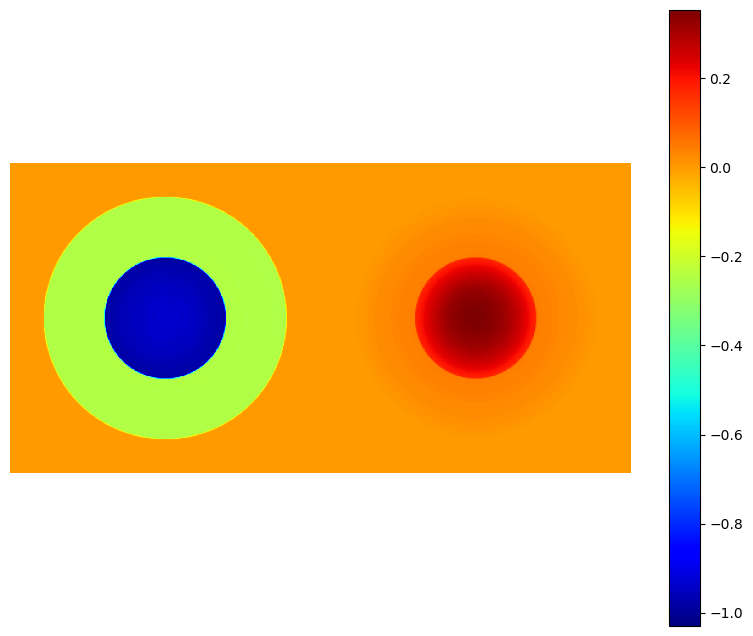

In [12]:
Real_result1 = np.concatenate((np.squeeze(Real_result[0,:,:]),np.squeeze(Real_result[1,:,:])),axis=1)
plt.imshow(Real_result1)
plt.jet()
plt.colorbar()
plt.axis('off')

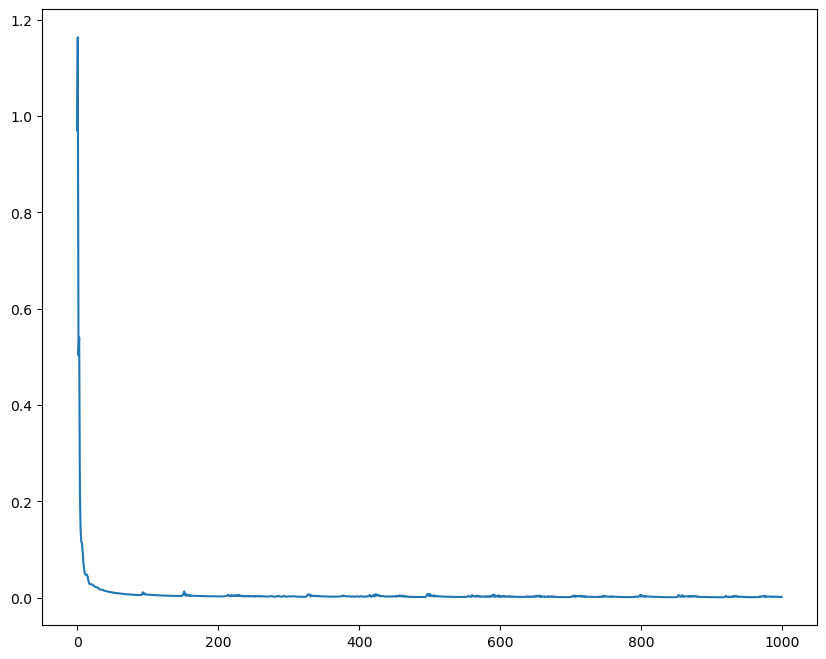

In [13]:
plt.plot(loss[0:])

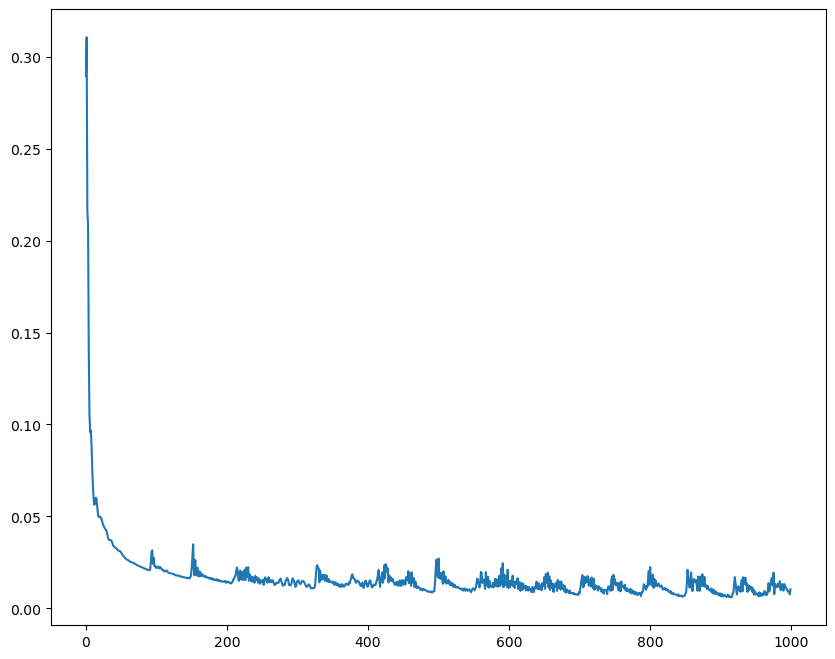

In [14]:
plt.plot(RMSE)
# plt.ylim(0,0.5)

In [15]:
print(np.min(RMSE))
print(np.min(loss))

0.0060074982017528315
0.000979602918960154


## DIP Data Save

In [16]:
# DIP_Brain = np.squeeze(Real_result[0,:,:])+1j*np.squeeze(Real_result[1,:,:])
# savemat('DIP_SURE_Phantom_fidelity.mat',{'Phantom_fidelity':DIP_Brain,'segmentation':segmentation})

In [17]:
DIP_Brain = np.squeeze(Real_result[0,:,:])+1j*np.squeeze(Real_result[1,:,:])
savemat('DIP40_SURE_Phantom_res0.5_new1000_1.mat',{'DIP_SURE':DIP_Brain,'segmentation':segmentation})

In [18]:
epsilon = sigma_ * 1e-2*4
print(epsilon)
epsilon = 1*1e-3* torch.max(net_input)
print(epsilon)


0.00046247756349498406
tensor(0.0015, device='cuda:0')
